# Data Augmentation

##### Keywords: data augmentation, gibbs sampler, MCMC

The idea is to construct iterative algorithms for sampling based on the introduction of unobserved data or **hidden** variables. Does the iterative part sound familiar? We did that in Gibbs sampling.

We'll soon see s deterministic version of this idea when we talk about the Expectation Maximization Algorithm (Dempster, Laird, and Rubin (1977)). Here we'll see a stochastic version from Tanner and Wong's (1987) *Data Augmentation algorithm for posterior sampling*. This was also explored in the physics by Swendsen and Wang's (1987) algorithm for sampling from Ising and Potts models. (Look it up, it relates to your homework!)

Indeed the general idea of introducing a hidden variable will also be exploited to introduce slice sampling and Hamiltonian Monte Carlo. Thus we shall see that the method is useful not only in "theory" to understand the decomposition of outcomes through hidden factors, but also in a practical way to construct sampling algorithms

The difference from Gibbs Sampling here is that we are thinking of a 1 (or lower) dimensional distribution or posterior we want to sample from, say $x$, and the other variable, say $y$, is to be treated as latent.

The game is, like in Gibbs, to construct a joint $p(x,y)$ such that we can sample from $p(x \vert y)$ and $p(y \vert x)$, and then find the marginal

$$p(x) = \int dy\,p(x,y).$$

The simplest form of a Data aumentation algorithm looks like this:

1. Draw $Y\sim p_{Y \vert X}(. \vert x)$ and call the observed value y
2. Draw $X_{n+1} \sim p_{X \vert Y}(. \vert y)$  


Here is an example

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

## Example


Suppose that $p_X$ is the standard normal density, i.e., 

$$p(x) = e^{-x^2/2}/\sqrt{2\pi}$$.

We'll pretend we dont know how to sample from it.

Take 

$$p(x, y) = 1/(\sqrt{2\pi}) \exp{\left\{-(x^2 - \sqrt{2} xy + y^2) \right\} } $$

which is a bivariate normal density with means equal to zero, variances equal
to one, and correlation equal to $1/\sqrt{2}$. The two conditionals are  normal, as we can see by completing the square and neglecting the part of the function that only depends on the variable not being conditioned upon ($e^{-y^2 }$ and $e^{-x^2 }$ respectively for the conditionals below).

$$ 
Y \vert X = x \, \, \sim N(x/\sqrt{2}, 1/2) \,\,\,  \rm{and} \,\,\, X \vert Y= y \,\,\sim N(y/\sqrt{2}, 1/2) $$

The x-marginal is 

$$\propto e^{-x^{2}/2} \int e^{-(y-x/\sqrt{2})^2 }dy $$ 

and clearly thus gets back the old normal we want to draw from.

In [2]:
N=100000
x=np.zeros(N)
x[0] = np.random.rand() # INITIALIZE
for i in np.arange(1,N):
    Y=sp.stats.norm.rvs(x[i-1]/np.sqrt(2), 0.5)
    x[i]=sp.stats.norm.rvs(Y/np.sqrt(2), 0.5)

Text(0.5, 0, 'x')

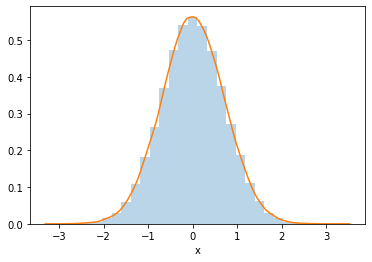

In [4]:
plt.hist(x, bins=30, alpha=0.3, density=True);
sns.kdeplot(x)
plt.xlabel('x')

## Data Augmentation is a Markov Chain Monte Carlo

Lets start from the "transition kernel" that we identified when we learnt about gibbs sampling

$$ h(x', x) = h(x' \vert x) = \int_Y p(x' \vert y) \, p(y \vert x)\, dy $$

where we have:

$$ p(x') = \int h(x' \vert x ) p(x)\,dx,$$

the stationarity condition.

Since we are dealing with probability densities, $h$ is always positive.

Also note 

$$
\begin{eqnarray}
  \int h(x' \vert x) dx' = \int_{X} \int_Y p(x' \vert y) \, p(y \vert x) \, dy \, dx' = \int_Y p(y \vert x) \left[ \int_X p(x' \vert y) dx' \right] dy  = \int_Y p(y \vert x) dy  = 1
\end{eqnarray}
$$

  
Therefore for each fixed $x$, $h(x' \vert x)$ is non-negative and integrates to 1. The function $h$ therefore
could be a Markov Chain transition density and if the current state is $x_n$ then the density of the next state 
would be $h(. \vert x_n)$. 

Also  note that the $h(x' \vert x)\, p(x)$ is symmetric 
in $(x,x')$. 
 
$$ h(x' \vert x)\, p(x) = p(x) \int_Y p(x' \vert y) \, p(y \vert x) \, dy = \int_Y \frac{p(x',y)\, p(x,y) }{p(y)} \, dy. $$

The rhs is symmetric in  $(x,x')$ and so is $ h(x' \vert x) p(x)$. 

The Markov chain generated with transition probability $h(x' \vert x)$ is **REVERSIBLE** and thus supports detailed balance.  


## Sequential Simulation

Now consider the practical issue of simulating the Markov chain $X$. Given that the current
state of the chain is $X_n = x$, how do we draw $X_{n+1}$ from the $h(. \vert x)$? The answer is
based on a sequential simulation technique that we now describe. 

Suppose we would like
to simulate a random vector from some pdf, $p_U(u)$, but we cannot do this directly. Suppose
further that $p_U$ is the u-marginal of the joint pdf $p_{U,V} (u, v)$ and that we have the ability to
make draws from $p_V(v)$ and from $p_{U,V} (u,v)$ for fixed $v$. If we draw $V\sim p_V(.)$, and then,
conditional on $V = v$, we draw $U \sim p_{U,V}(. \vert v)$, then the observed pair, $(u, v)$, is a draw from
$p_{U,V}$, which means that $u$ is a draw from $p_U$. We now can 
explain how it is used to simulate from $h(. \vert x)$.

Define 

$$ H(x',y \vert  x) = p(x' \vert y) p(y \vert x) $$

We apply the procedure above with $h(. \vert x)$ and $H(.,. \vert x)$ playing the roles of 
$p_U(.)$ and $p_{U,V}(.,.)$ respectively. We of course need the marginal of
$H(x', y \vert x)$ which is $p(y \vert x)$ and the conditional density of $X'$ given $Y=y$  which is

$$ \frac{ H(x',y \vert x) }{p(y \vert x)} = p(x' \vert y) $$

which gives us the procedure above:

1. Draw $Y\sim p_{Y \vert X}(. \vert x)$ and call the observed value y
2. Draw $X_{n+1} \sim p_{X \vert Y}(. \vert y)$  